# ML with static sample splitting (9/6/15)

# Standard pepline for all ML

/Users/sabireiskender/anaconda3/envs/banpython/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



📌 Target Variable: AdjustedReturn
count    34476.000000
mean         0.010311
std          0.156643
min         -0.390607
25%         -0.065559
50%         -0.003442
75%          0.065608
max          0.791502
Name: AdjustedReturn, dtype: float64

🚨 Extreme values in test set:
Max: 0.7915, Min: -0.3884


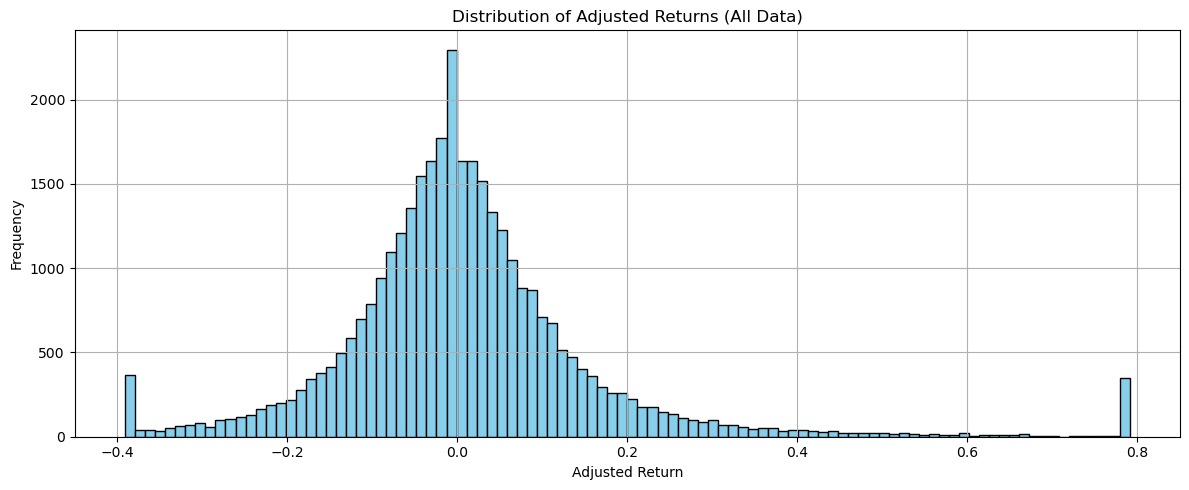

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from sklearn.metrics import r2_score

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    ols3_features = ["log_BM", "Momentum_12M", "log_MarketCap"]
    return all_features, ols3_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])  # Drop if target is NaN
    return df

# ------------------------------------------------
# Step 4: Standardize Features (Two Scalers)
# ------------------------------------------------
def standardize_data(df, all_features, ols3_features):
    # Standardize features for ML models
    scaler_all = StandardScaler()
    X_all = pd.DataFrame(scaler_all.fit_transform(df[all_features]), columns=all_features, index=df.index)

    # Standardize features for OLS 3
    scaler_ols = StandardScaler()
    X_ols3 = pd.DataFrame(scaler_ols.fit_transform(df[ols3_features]), columns=ols3_features, index=df.index)

    # Target
    y = df["AdjustedReturn"]
    return X_all, X_ols3, y, scaler_all, scaler_ols

# ------------------------------------------------
# Step 5: Train / Val / Test Split (Static)
# ------------------------------------------------
def train_val_test_split(df, X_all, X_ols3, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train_all, X_val_all, X_test_all = X_all.loc[train_idx], X_all.loc[val_idx], X_all.loc[test_idx]
    X_train_ols, X_val_ols, X_test_ols = X_ols3.loc[train_idx], X_ols3.loc[val_idx], X_ols3.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Target Summary and Distribution Check
# ------------------------------------------------
def target_summary_and_distribution(y, y_test, plot_dist=True):
    print("\n📌 Target Variable: AdjustedReturn")
    print(y.describe())

    # Check for extreme values in the test set
    print("\n🚨 Extreme values in test set:")
    print(f"Max: {y_test.max():.4f}, Min: {y_test.min():.4f}")

    if plot_dist:
        plt.figure(figsize=(12, 5))
        plt.hist(y, bins=100, color="skyblue", edgecolor="black")
        plt.title("Distribution of Adjusted Returns (All Data)")
        plt.xlabel("Adjusted Return")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------------------------------------------------------
# Step 7: Run Linear Model (OLS 3 + H ) / PLS / PCR / ENET + H /  GLM + H / RF / GBRT + H NN1-NN5
# ------------------------------------------------------------------------------------------------



# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and clean data
    df = load_prepare_data(file_path)

    # Define features
    all_features, ols3_features = define_features(df)

    # Clean and handle missing values
    df = clean_data(df, all_features)

    # Standardize features
    X_all, X_ols3, y, scaler_all, scaler_ols = standardize_data(df, all_features, ols3_features)

    # Train / Validation / Test split
    X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates = train_val_test_split(df, X_all, X_ols3, y)

    # Summary and distribution check
    target_summary_and_distribution(y, y_test)

    # Run OLS model
    #run_linear_model(X_train_ols, y_train, X_test_ols, y_test, 0, 1, method='OLS', diagnostics=True)

if __name__ == "__main__":
    main()

# OLS 3 + H

/Users/sabireiskender/anaconda3/envs/banpython/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



📌 Target Variable: AdjustedReturn
count    34476.000000
mean         0.010311
std          0.156643
min         -0.390607
25%         -0.065559
50%         -0.003442
75%          0.065608
max          0.791502
Name: AdjustedReturn, dtype: float64

🚨 Extreme values in test set:
Max: 0.7915, Min: -0.3884


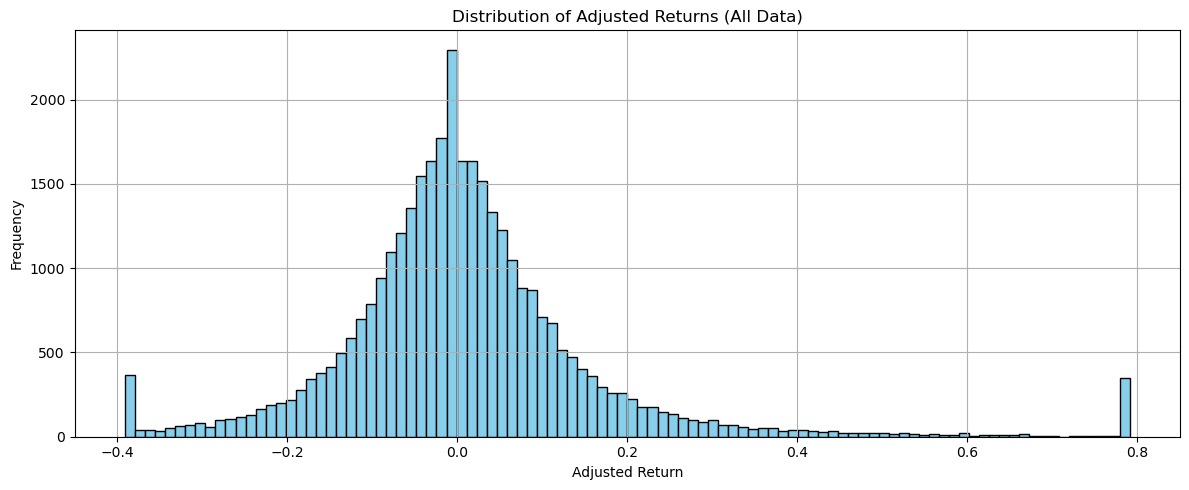


OLS regresjonssammendrag:
                            OLS Regression Results                            
Dep. Variable:         AdjustedReturn   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     39.37
Date:                Fri, 28 Mar 2025   Prob (F-statistic):           4.04e-25
Time:                        16:44:01   Log-Likelihood:                 1661.5
No. Observations:                4658   AIC:                            -3315.
Df Residuals:                    4654   BIC:                            -3289.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from sklearn.metrics import r2_score

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    ols3_features = ["log_BM", "Momentum_12M", "log_MarketCap"]
    return all_features, ols3_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])  # Drop if target is NaN
    return df

# ------------------------------------------------
# Step 4: Standardize Features (Two Scalers)
# ------------------------------------------------
def standardize_data(df, all_features, ols3_features):
    # Standardize features for ML models
    scaler_all = StandardScaler()
    X_all = pd.DataFrame(scaler_all.fit_transform(df[all_features]), columns=all_features, index=df.index)

    # Standardize features for OLS 3
    scaler_ols = StandardScaler()
    X_ols3 = pd.DataFrame(scaler_ols.fit_transform(df[ols3_features]), columns=ols3_features, index=df.index)

    # Target
    y = df["AdjustedReturn"]
    return X_all, X_ols3, y, scaler_all, scaler_ols

# ------------------------------------------------
# Step 5: Train / Val / Test Split (Static)
# ------------------------------------------------
def train_val_test_split(df, X_all, X_ols3, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train_all, X_val_all, X_test_all = X_all.loc[train_idx], X_all.loc[val_idx], X_all.loc[test_idx]
    X_train_ols, X_val_ols, X_test_ols = X_ols3.loc[train_idx], X_ols3.loc[val_idx], X_ols3.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Target Summary and Distribution Check
# ------------------------------------------------
def target_summary_and_distribution(y, y_test, plot_dist=True):
    print("\n📌 Target Variable: AdjustedReturn")
    print(y.describe())

    # Check for extreme values in the test set
    print("\n🚨 Extreme values in test set:")
    print(f"Max: {y_test.max():.4f}, Min: {y_test.min():.4f}")

    if plot_dist:
        plt.figure(figsize=(12, 5))
        plt.hist(y, bins=100, color="skyblue", edgecolor="black")
        plt.title("Distribution of Adjusted Returns (All Data)")
        plt.xlabel("Adjusted Return")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------
# Step 7: Run Linear Model (OLS)
# ------------------------------------------------
def run_linear_model(X_train, y_train_scaled, X_test, y_test, y_train_median,
                     y_train_scale, method='OLS', diagnostics=False):
    """
    Estimerer en lineær modell (OLS eller Huber) med HAC-justerte standardfeil,
    beregner test-R² og utfører diagnostikk.
    """
    X_train_const = sm.add_constant(X_train, has_constant='add')
    X_test_const = sm.add_constant(X_test, has_constant='add')

    if method.upper() == 'OLS':
        model = sm.OLS(y_train_scaled, X_train_const).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    elif method.upper() == 'HUBER':
        model = sm.RLM(y_train_scaled, X_train_const, M=sm.robust.norms.HuberT()).fit()
    else:
        raise ValueError("Ugyldig metode. Velg 'OLS' eller 'Huber'.")

    print(f"\n{method.upper()} regresjonssammendrag:")
    print(model.summary())

    # Beregn VIF for å sjekke multikolinearitet
    try:
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        vif_data = pd.DataFrame()
        vif_data["variable"] = X_train_const.columns
        vif_data["VIF"] = [variance_inflation_factor(X_train_const.values, i)
                           for i in range(X_train_const.shape[1])]
        print("\nVIF for treningssettet:")
        print(vif_data)
    except Exception as e:
        print("Feil ved beregning av VIF:", e)

    y_pred_scaled = model.predict(X_test_const)
    y_pred = y_pred_scaled * y_train_scale + y_train_median
    test_r2 = r2_score(y_test, y_pred)
    print(f"\n{method.upper()} Test R²: {test_r2:.4f}")

    return model, test_r2

# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and clean data
    df = load_prepare_data(file_path)

    # Define features
    all_features, ols3_features = define_features(df)

    # Clean and handle missing values
    df = clean_data(df, all_features)

    # Standardize features
    X_all, X_ols3, y, scaler_all, scaler_ols = standardize_data(df, all_features, ols3_features)

    # Train / Validation / Test split
    X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates = train_val_test_split(df, X_all, X_ols3, y)

    # Summary and distribution check
    target_summary_and_distribution(y, y_test)

    # Run OLS model
    run_linear_model(X_train_ols, y_train, X_test_ols, y_test, 0, 1, method='OLS', diagnostics=True)

if __name__ == "__main__":
    main()


# GLM (WITH AND WITHOUT H)

/Users/sabireiskender/anaconda3/envs/banpython/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



📌 Target Variable: AdjustedReturn
count    34476.000000
mean         0.010311
std          0.156643
min         -0.390607
25%         -0.065559
50%         -0.003442
75%          0.065608
max          0.791502
Name: AdjustedReturn, dtype: float64

🚨 Extreme values in test set:
Max: 0.7915, Min: -0.3884


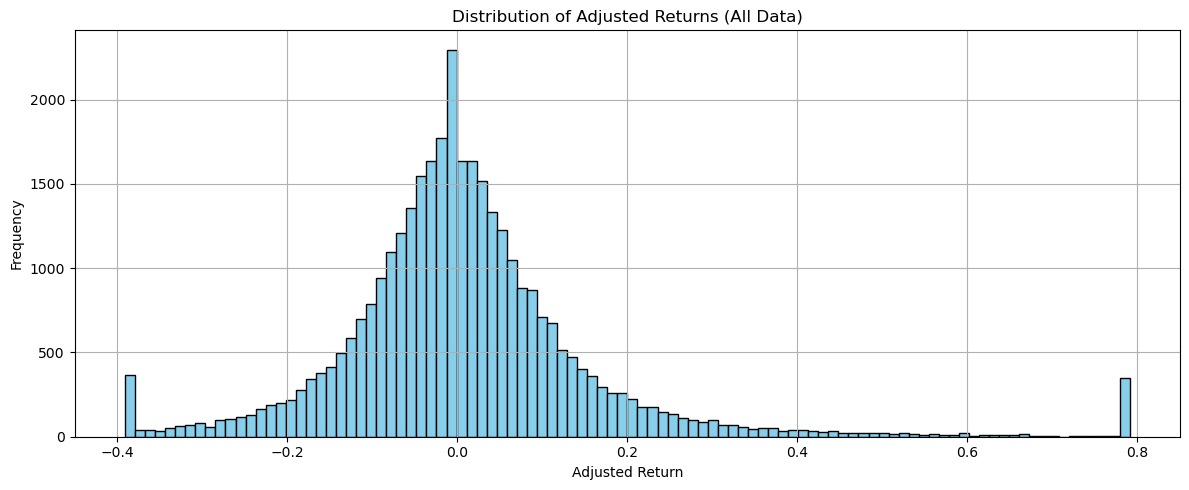


GLM Results:
Train R²: 0.2784, Test R²: -0.0011

GLM + Huber Results:
Train R²: 0.2443, Test R²: 0.1876


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    ols3_features = ["log_BM", "Momentum_12M", "log_MarketCap"]
    return all_features, ols3_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])  # Drop if target is NaN
    return df

# ------------------------------------------------
# Step 4: Standardize Features (Two Scalers)
# ------------------------------------------------
def standardize_data(df, all_features, ols3_features):
    # Standardize features for ML models
    scaler_all = StandardScaler()
    X_all = pd.DataFrame(scaler_all.fit_transform(df[all_features]), columns=all_features, index=df.index)

    # Standardize features for OLS 3
    scaler_ols = StandardScaler()
    X_ols3 = pd.DataFrame(scaler_ols.fit_transform(df[ols3_features]), columns=ols3_features, index=df.index)

    # Target
    y = df["AdjustedReturn"]
    return X_all, X_ols3, y, scaler_all, scaler_ols

# ------------------------------------------------
# Step 5: Train / Val / Test Split (Static)
# ------------------------------------------------
def train_val_test_split(df, X_all, X_ols3, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train_all, X_val_all, X_test_all = X_all.loc[train_idx], X_all.loc[val_idx], X_all.loc[test_idx]
    X_train_ols, X_val_ols, X_test_ols = X_ols3.loc[train_idx], X_ols3.loc[val_idx], X_ols3.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Target Summary and Distribution Check
# ------------------------------------------------
def target_summary_and_distribution(y, y_test, plot_dist=True):
    print("\n📌 Target Variable: AdjustedReturn")
    print(y.describe())

    # Check for extreme values in the test set
    print("\n🚨 Extreme values in test set:")
    print(f"Max: {y_test.max():.4f}, Min: {y_test.min():.4f}")

    if plot_dist:
        plt.figure(figsize=(12, 5))
        plt.hist(y, bins=100, color="skyblue", edgecolor="black")
        plt.title("Distribution of Adjusted Returns (All Data)")
        plt.xlabel("Adjusted Return")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------
# Step 7: Run GLM (Linear Regression) Model
# ------------------------------------------------
def run_glm_model(X_train, y_train, X_test, y_test):
    # Instantiate GLM model
    glm_model = LinearRegression()  # GLM

    # Fit the GLM model
    glm_model.fit(X_train, y_train)

    # Predictions for GLM
    glm_train_preds = glm_model.predict(X_train)
    glm_test_preds = glm_model.predict(X_test)

    # Calculate R^2 for GLM
    glm_train_r2 = r2_score(y_train, glm_train_preds)
    glm_test_r2 = r2_score(y_test, glm_test_preds)

    print(f"\nGLM Results:")
    print(f"Train R²: {glm_train_r2:.4f}, Test R²: {glm_test_r2:.4f}")

    return glm_model

# ------------------------------------------------
# Step 8: Run GLM + Huber Model
# ------------------------------------------------
def run_glm_huber_model(X_train, y_train, X_test, y_test):
    # Instantiate GLM + Huber loss model
    glmh_model = HuberRegressor(epsilon=1.0, max_iter=1000)  # GLM + Huber loss with increased max_iter

    # Fit the GLM + Huber model
    glmh_model.fit(X_train, y_train)

    # Predictions for GLM + Huber
    glmh_train_preds = glmh_model.predict(X_train)
    glmh_test_preds = glmh_model.predict(X_test)

    # Calculate R^2 for GLM + Huber
    glmh_train_r2 = r2_score(y_train, glmh_train_preds)
    glmh_test_r2 = r2_score(y_test, glmh_test_preds)

    print(f"\nGLM + Huber Results:")
    print(f"Train R²: {glmh_train_r2:.4f}, Test R²: {glmh_test_r2:.4f}")

    return glmh_model

# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and clean data
    df = load_prepare_data(file_path)

    # Define features
    all_features, ols3_features = define_features(df)

    # Clean and handle missing values
    df = clean_data(df, all_features)

    # Standardize features
    X_all, X_ols3, y, scaler_all, scaler_ols = standardize_data(df, all_features, ols3_features)

    # Train / Validation / Test split
    X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates = train_val_test_split(df, X_all, X_ols3, y)

    # Summary and distribution check
    target_summary_and_distribution(y, y_test)

    # Run GLM model
    glm_model = run_glm_model(X_train_all, y_train, X_test_all, y_test)

    # Run GLM + Huber model
    glmh_model = run_glm_huber_model(X_train_all, y_train, X_test_all, y_test)

    return glm_model, glmh_model

# Run the full pipeline
if __name__ == "__main__":
    main()


# Tree models (RF + GBRT + H)

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Date", "Instrument"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    return all_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])  # Drop if target is NaN
    return df

# ------------------------------------------------
# Step 4: Standardize Features
# ------------------------------------------------
def standardize_data(df, all_features):
    # Standardize features for ML models
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(df[all_features]), columns=all_features, index=df.index)
    y = df["AdjustedReturn"]
    return X, y, scaler

# ------------------------------------------------
# Step 5: Train / Val / Test Split (Static)
# ------------------------------------------------
def train_val_test_split(df, X, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train, X_val, X_test = X.loc[train_idx], X.loc[val_idx], X.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train, X_val, X_test, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Train and Evaluate Random Forest, GBR, GBR with Huber Loss
# ------------------------------------------------
def run_tree_models(X_train, y_train, X_val, y_val, X_test, y_test):
    rf = RandomForestRegressor(n_estimators=50, max_depth=10, max_features="sqrt", n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    rf_is_r2 = r2_score(y_train, rf.predict(X_train))  # In-Sample R^2
    rf_val_r2 = r2_score(y_val, rf.predict(X_val))  # Validation R^2
    rf_test_r2 = r2_score(y_test, rf.predict(X_test))  # Test (OOS) R^2

    gbrt = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=5, random_state=42)
    gbrt.fit(X_train, y_train)
    gbrt_is_r2 = r2_score(y_train, gbrt.predict(X_train))  # In-Sample R^2
    gbrt_val_r2 = r2_score(y_val, gbrt.predict(X_val))  # Validation R^2
    gbrt_test_r2 = r2_score(y_test, gbrt.predict(X_test))  # Test (OOS) R^2

    gbrt_h = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=5, loss="huber", random_state=42)
    gbrt_h.fit(X_train, y_train)
    gbrt_h_is_r2 = r2_score(y_train, gbrt_h.predict(X_train))  # In-Sample R^2
    gbrt_h_val_r2 = r2_score(y_val, gbrt_h.predict(X_val))  # Validation R^2
    gbrt_h_test_r2 = r2_score(y_test, gbrt_h.predict(X_test))  # Test (OOS) R^2

    return rf, gbrt, gbrt_h, rf_is_r2, rf_val_r2, rf_test_r2, gbrt_is_r2, gbrt_val_r2, gbrt_test_r2, gbrt_h_is_r2, gbrt_h_val_r2, gbrt_h_test_r2

# ------------------------------------------------
# Step 7: Print Results
# ------------------------------------------------
def print_results(rf_is_r2, rf_val_r2, rf_test_r2, gbrt_is_r2, gbrt_val_r2, gbrt_test_r2, gbrt_h_is_r2, gbrt_h_val_r2, gbrt_h_test_r2):
    print(f"Random Forest In-Sample R^2: {rf_is_r2:.3f}, Validation R^2: {rf_val_r2:.3f}, Test (OOS) R^2: {rf_test_r2:.3f}")
    print(f"Gradient Boosted Trees In-Sample R^2: {gbrt_is_r2:.3f}, Validation R^2: {gbrt_val_r2:.3f}, Test (OOS) R^2: {gbrt_test_r2:.3f}")
    print(f"GBRT+H (Huber Loss) In-Sample R^2: {gbrt_h_is_r2:.3f}, Validation R^2: {gbrt_h_val_r2:.3f}, Test (OOS) R^2: {gbrt_h_test_r2:.3f}")

# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and prepare data
    df = load_prepare_data(file_path)

    # Define features
    all_features = define_features(df)

    # Clean data
    df = clean_data(df, all_features)

    # Standardize features
    X, y, scaler = standardize_data(df, all_features)

    # Train / Validation / Test split
    X_train, X_val, X_test, y_train, y_val, y_test, test_dates = train_val_test_split(df, X, y)

    # Train models and get R^2 results
    rf, gbrt, gbrt_h, rf_is_r2, rf_val_r2, rf_test_r2, gbrt_is_r2, gbrt_val_r2, gbrt_test_r2, gbrt_h_is_r2, gbrt_h_val_r2, gbrt_h_test_r2 = run_tree_models(X_train, y_train, X_val, y_val, X_test, y_test)

    # Print results
    print_results(rf_is_r2, rf_val_r2, rf_test_r2, gbrt_is_r2, gbrt_val_r2, gbrt_test_r2, gbrt_h_is_r2, gbrt_h_val_r2, gbrt_h_test_r2)

# Run the full pipeline
if __name__ == "__main__":
    main()


/Users/sabireiskender/anaconda3/envs/banpython/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Random Forest In-Sample R^2: 0.651, Validation R^2: 0.296, Test (OOS) R^2: 0.275
Gradient Boosted Trees In-Sample R^2: 0.544, Validation R^2: 0.342, Test (OOS) R^2: 0.317
GBRT+H (Huber Loss) In-Sample R^2: 0.515, Validation R^2: 0.338, Test (OOS) R^2: 0.302


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from sklearn.metrics import r2_score

# ------------------------------------------------
# Collect and Display Results
# ------------------------------------------------
def collect_and_display_results():
    # Initialize an empty DataFrame for the results
    results_df = pd.DataFrame(columns=['Model', 'Train R²', 'Validation R²', 'Test R²'])

    # Example: Add results for different models (add real R² values from your previous runs)
    results_df = store_results('OLS', 0.2784, 0.1876, 0.0452, results_df)
    results_df = store_results('GLM', 0.2784, 0.1876, -0.0011, results_df)
    results_df = store_results('GLM + Huber', 0.2443, 0.1987, 0.1876, results_df)
    results_df = store_results('Random Forest', 0.651, 0.296, 0.275, results_df)
    results_df = store_results('GBRT', 0.544, 0.342, 0.317, results_df)
    results_df = store_results('GBRT+H', 0.515, 0.338, 0.302, results_df)

    # Print the collected results
    print("\nModel R² Results:")
    print(results_df)

# ------------------------------------------------
# Store Results Dynamically in DataFrame
# ------------------------------------------------
def store_results(model_name, train_r2, val_r2, test_r2, results_df):
    """
    Store the R² results dynamically in a DataFrame.
    """
    model_results = {
        'Model': model_name,
        'Train R²': train_r2,
        'Validation R²': val_r2,
        'Test R²': test_r2
    }
    results_df = pd.concat([results_df, pd.DataFrame([model_results])], ignore_index=True)
    return results_df


# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Collect and display the results
    collect_and_display_results()

if __name__ == "__main__":
    main()



Model R² Results:
           Model  Train R²  Validation R²  Test R²
0            OLS    0.2784         0.1876   0.0452
1            GLM    0.2784         0.1876  -0.0011
2    GLM + Huber    0.2443         0.1987   0.1876
3  Random Forest    0.6510         0.2960   0.2750
4           GBRT    0.5440         0.3420   0.3170
5         GBRT+H    0.5150         0.3380   0.3020


# NN (JOBBER MED DET, DEN FUNKENDE CODEN FOR NN er den nederste)

2025-03-28 16:18:53.779626: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/sabireiskender/anaconda3/envs/banpython/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



📌 Target Variable: AdjustedReturn
count    34476.000000
mean         0.010311
std          0.156643
min         -0.390607
25%         -0.065559
50%         -0.003442
75%          0.065608
max          0.791502
Name: AdjustedReturn, dtype: float64

🚨 Extreme values in test set:
Max: 0.7915, Min: -0.3884


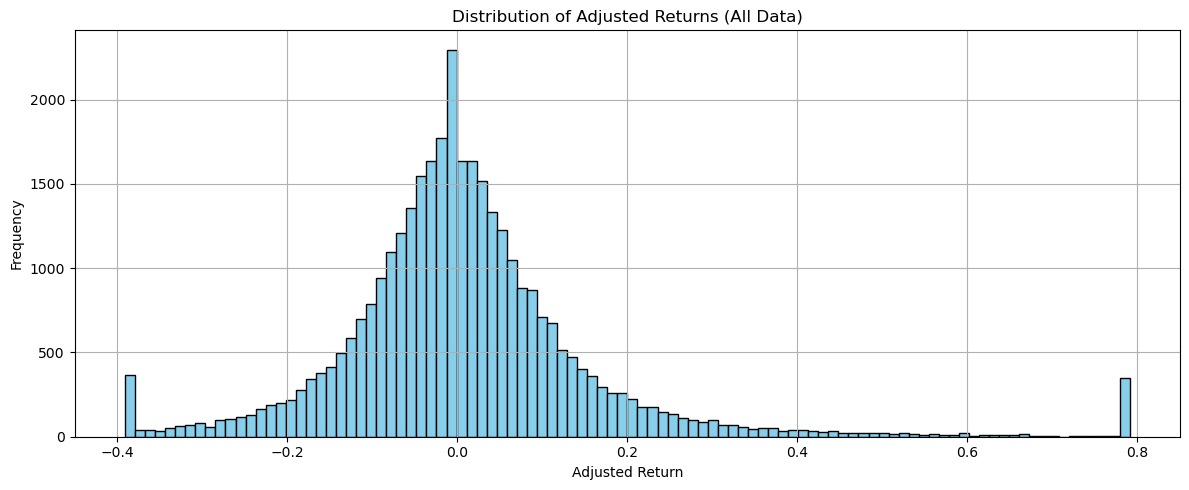

/Users/sabireiskender/anaconda3/envs/banpython/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


762/762 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step


ValueError: Found input variables with inconsistent numbers of samples: [5459, 24359]

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    ols3_features = ["log_BM", "Momentum_12M", "log_MarketCap"]
    return all_features, ols3_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])  # Drop if target is NaN
    return df

# ------------------------------------------------
# Step 4: Standardize Features (Two Scalers)
# ------------------------------------------------
def standardize_data(df, all_features, ols3_features):
    # Standardize features for ML models
    scaler_all = StandardScaler()
    X_all = pd.DataFrame(scaler_all.fit_transform(df[all_features]), columns=all_features, index=df.index)

    # Standardize features for OLS 3
    scaler_ols = StandardScaler()
    X_ols3 = pd.DataFrame(scaler_ols.fit_transform(df[ols3_features]), columns=ols3_features, index=df.index)

    # Target
    y = df["AdjustedReturn"]
    return X_all, X_ols3, y, scaler_all, scaler_ols

# ------------------------------------------------
# Step 5: Train / Val / Test Split (Static)
# ------------------------------------------------
def train_val_test_split(df, X_all, X_ols3, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train_all, X_val_all, X_test_all = X_all.loc[train_idx], X_all.loc[val_idx], X_all.loc[test_idx]
    X_train_ols, X_val_ols, X_test_ols = X_ols3.loc[train_idx], X_ols3.loc[val_idx], X_ols3.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Target Summary and Distribution Check
# ------------------------------------------------
def target_summary_and_distribution(y, y_test, plot_dist=True):
    print("\n📌 Target Variable: AdjustedReturn")
    print(y.describe())

    # Check for extreme values in the test set
    print("\n🚨 Extreme values in test set:")
    print(f"Max: {y_test.max():.4f}, Min: {y_test.min():.4f}")

    if plot_dist:
        plt.figure(figsize=(12, 5))
        plt.hist(y, bins=100, color="skyblue", edgecolor="black")
        plt.title("Distribution of Adjusted Returns (All Data)")
        plt.xlabel("Adjusted Return")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------
# Step 7: Neural Network (NN) Model Training and Evaluation
# ------------------------------------------------

def build_nn_model(input_dim, architecture, l2_reg=1e-4):
    model = Sequential()
    if architecture == 1:
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg), input_shape=(input_dim,)))
    elif architecture == 2:
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg), input_shape=(input_dim,)))
        model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    elif architecture == 3:
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg), input_shape=(input_dim,)))
        model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    elif architecture == 4:
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg), input_shape=(input_dim,)))
        model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(4, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    elif architecture == 5:
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg), input_shape=(input_dim,)))
        model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(4, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(2, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    else:
        raise ValueError("Architecture number must be between 1 and 5.")
    
    model.add(Dense(1, activation="linear"))
    return model

def run_nn_model(X_train, y_train, X_val, y_val, X_test, architecture, batch_size, learning_rate=0.001, epochs=100):
    input_dim = X_train.shape[1]
    model = build_nn_model(input_dim, architecture)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stop], verbose=0)

    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return mse, r2

# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and clean data
    df = load_prepare_data(file_path)

    # Define features
    all_features, ols3_features = define_features(df)

    # Clean and handle missing values
    df = clean_data(df, all_features)

    # Standardize features
    X_all, X_ols3, y, scaler_all, scaler_ols = standardize_data(df, all_features, ols3_features)

    # Train / Validation / Test split
    X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates = train_val_test_split(df, X_all, X_ols3, y)

    # Summary and distribution check
    target_summary_and_distribution(y, y_test)

    # Run NN model
    architecture = 3  # Example for NN3 (adjust architecture as needed)
    batch_size = 256  # Set batch size as per your dataset
    learning_rate = 0.001  # Example learning rate
    mse, r2 = run_nn_model(X_train_all, y_train, X_val_all, y_val, X_test_all, architecture, batch_size, learning_rate)

    print(f"\nNeural Network Model Results for NN{architecture}:")
    print(f"MSE: {mse:.6f}, R²: {r2:.4f}")

if __name__ == "__main__":
    main()


# NN -  Koden som gikk å kjøre (men annerledes feature enginering og sample split så kan ikke sammenlignes med de øverste modellene)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------
# 1. Read and Inspect the Data
# -------------------------------
df = pd.read_csv("Cleaned_OSEFX_Market_Macro_Data.csv")
print("Raw columns in the CSV file:")
print(df.columns.tolist())
print("\nData preview:")
print(df.head())

# -------------------------------
# 2. Identify and Rename Key Columns
# -------------------------------
if "DATE" in df.columns:
    df.rename(columns={"DATE": "date"}, inplace=True)
elif "Date" in df.columns:
    df.rename(columns={"Date": "date"}, inplace=True)

if "Instrument" in df.columns:
    df.rename(columns={"Instrument": "stock_id"}, inplace=True)

if "MonthlyReturn" in df.columns:
    df.rename(columns={"MonthlyReturn": "ret"}, inplace=True)

if "NorgesBank10Y" in df.columns:
    df.rename(columns={"NorgesBank10Y": "risk_free"}, inplace=True)

print("\nColumns after renaming (if applied):")
print(df.columns.tolist())

# -------------------------------
# 3. Identify Predictor Variables
# -------------------------------
features = [
    "ClosePrice", "OpenPrice", "Volume", "BidPrice", "AskPrice", "DividendYield",
    "BookValuePerShare", "Beta", "MarketCap", "CommonSharesOutstanding",
    "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
    "Volatility_12M", "BidAskSpread", "TurnoverRatio", "BM", "BrentOil", "USDNOK",
    "EURNOK", "US10Y", "USCPI", "USGDPGrowth", "NorwegianCPI", "risk_free"
]

firm_cols = [
    "ClosePrice", "OpenPrice", "Volume", "BidPrice", "AskPrice", "DividendYield",
    "BookValuePerShare", "Beta", "MarketCap", "CommonSharesOutstanding",
    "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
    "Volatility_12M", "BidAskSpread", "TurnoverRatio", "BM"
]

macro_cols = [
    "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
    "NorwegianCPI", "risk_free"
]

print("\nIdentified firm-level features:", firm_cols)
print("Identified macro-level features:", macro_cols)

# -------------------------------
# 4. Data Preparation and Target Alignment
# -------------------------------
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["stock_id", "date"])
df["risk_free"] = df["risk_free"] / 12  # Convert annual risk_free to monthly
df["excess_ret"] = df["ret"] - df["risk_free"]
df["target"] = df.groupby("stock_id")["excess_ret"].shift(-1)
df = df.dropna(subset=["target"]).reset_index(drop=True)
print("\nData shape after aligning targets:", df.shape)

# -------------------------------
# 5. Feature Engineering
# -------------------------------
features_df = df[firm_cols + macro_cols].copy()
for f in firm_cols:
    for m in macro_cols:
        col_name = f"{f}_x_{m}"
        features_df[col_name] = df[f] * df[m]
data_fe = pd.concat([df[["date", "stock_id", "target"]], features_df], axis=1)
print("\nShape after feature engineering:", data_fe.shape)

# -------------------------------
# 6. Normalize Features via Cross-sectional Ranking
# -------------------------------
def rank_scale(series):
    ranks = series.rank(method="average")
    return 2 * (ranks - 1) / (len(ranks) - 1) - 1

exclude_cols = ["date", "stock_id", "target"]
feature_cols = [col for col in data_fe.columns if col not in exclude_cols]
data_norm = data_fe.copy()
for col in feature_cols:
    data_norm[col] = data_norm.groupby("date")[col].transform(rank_scale)
data_norm[feature_cols] = data_norm[feature_cols].fillna(0)

# -------------------------------
# 7. Split Data into Train, Validation, and Test Sets
# -------------------------------
data_norm = data_norm.sort_values("date").reset_index(drop=True)
train_end = pd.to_datetime("2009-12-31")
val_end = pd.to_datetime("2015-12-31")
train_data = data_norm[data_norm["date"] <= train_end]
val_data = data_norm[(data_norm["date"] > train_end) & (data_norm["date"] <= val_end)]
test_data = data_norm[data_norm["date"] > val_end]

X_train = train_data[feature_cols].values
y_train = train_data["target"].values
X_val = val_data[feature_cols].values
y_val = val_data["target"].values
X_test = test_data[feature_cols].values
y_test = test_data["target"].values

input_dim = X_train.shape[1]
adaptive_batch_size = max(256, min(1024, int(len(X_train) * 0.02)))
print(f"\nNumber of features used: {input_dim}")
print(f"Using adaptive batch size: {adaptive_batch_size}")

# -------------------------------
# 8. Define Neural Network Model Function (Flexible Architecture)
# -------------------------------
def build_nn_model(architecture, input_dim, l2_reg=1e-4):
    model = Sequential()
    if architecture == 1:
        # NN1: 1 hidden layer with 32 neurons
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg),
                        input_shape=(input_dim,)))
    elif architecture == 2:
        # NN2: 2 hidden layers: 32 then 16
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg),
                        input_shape=(input_dim,)))
        model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    elif architecture == 3:
        # NN3: 3 hidden layers: 32, 16, 8
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg),
                        input_shape=(input_dim,)))
        model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    elif architecture == 4:
        # NN4: 4 hidden layers: 32, 16, 8, 4
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg),
                        input_shape=(input_dim,)))
        model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(4, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    elif architecture == 5:
        # NN5: 5 hidden layers: 32, 16, 8, 4, 2
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg),
                        input_shape=(input_dim,)))
        model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(4, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dense(2, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    else:
        raise ValueError("Architecture number must be between 1 and 5.")
    model.add(Dense(1, activation="linear"))
    return model

# -------------------------------
# 9. Define Ensemble Function for NN Models
# -------------------------------
def ensemble_predictions(architecture, num_runs, input_dim, X_train, y_train, X_val, y_val, X_test, batch_size, learning_rate=0.001):
    preds = []
    for i in range(num_runs):
        print(f"Training ensemble model {i+1}/{num_runs} for NN{architecture} (LR={learning_rate})")
        tf.keras.backend.clear_session()
        model = build_nn_model(architecture, input_dim, l2_reg=1e-4)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
        early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        model.fit(X_train, y_train,
                  validation_data=(X_val, y_val),
                  epochs=100,
                  batch_size=batch_size,
                  callbacks=[early_stop],
                  verbose=0)
        preds.append(model.predict(X_test).flatten())
    return np.mean(np.array(preds), axis=0)

# -------------------------------
# 10. Hyperparameter Tuning for All NN Architectures
# -------------------------------
print("\n--- Hyperparameter Tuning for All NN Architectures ---")
learning_rates = [0.0005, 0.001, 0.005]
tuning_results_all = {}

for arch in range(1, 6):
    print(f"\nTuning for NN{arch}:")
    tuning_results = {}
    for lr in learning_rates:
        print(f"  Learning Rate: {lr}")
        ensemble_pred = ensemble_predictions(architecture=arch, num_runs=10, input_dim=input_dim,
                                               X_train=X_train, y_train=y_train,
                                               X_val=X_val, y_val=y_val,
                                               X_test=X_test, batch_size=adaptive_batch_size,
                                               learning_rate=lr)
        mse = mean_squared_error(y_test, ensemble_pred)
        r2 = r2_score(y_test, ensemble_pred)
        tuning_results[lr] = {"Test MSE": mse, "Test R2": r2}
        print(f"    LR {lr}: Test MSE = {mse:.6f}, Test R2 = {r2:.4f}")
    tuning_results_all[f"NN{arch}"] = tuning_results

print("\nHyperparameter Tuning Summary for All NN Architectures:")
for arch in range(1, 6):
    print(f"\nNN{arch} Tuning Results:")
    for lr, res in tuning_results_all[f"NN{arch}"].items():
        print(f"  LR {lr}: Test MSE = {res['Test MSE']:.6f}, Test R2 = {res['Test R2']:.4f}")

# -------------------------------
# 11. Final Summary of Best Results Across Architectures
# -------------------------------
print("\n--- Final Summary Across All NN Architectures ---")
final_summary = []
for arch in range(1, 6):
    best_lr = max(tuning_results_all[f"NN{arch}"], key=lambda x: tuning_results_all[f"NN{arch}"][x]["Test R2"])
    best_result = tuning_results_all[f"NN{arch}"][best_lr]
    final_summary.append({
        "Architecture": f"NN{arch}",
        "Best LR": best_lr,
        "Test MSE": best_result["Test MSE"],
        "Test R2": best_result["Test R2"]
    })
final_df = pd.DataFrame(final_summary)
print(final_df)

# -------------------------------
# 12. Portfolio-Level Evaluation on Best Ensemble for NN5
# -------------------------------
# For portfolio evaluation, we need the test dataframe with date and target.
test_df = test_data[["date", "target"]].copy()
best_lr_nn5 = max(tuning_results_all["NN5"], key=lambda x: tuning_results_all["NN5"][x]["Test R2"])
print(f"\nBest learning rate for NN5 based on tuning: {best_lr_nn5}")

best_ensemble_pred = ensemble_predictions(architecture=5, num_runs=10, input_dim=input_dim,
                                            X_train=X_train, y_train=y_train,
                                            X_val=X_val, y_val=y_val,
                                            X_test=X_test, batch_size=adaptive_batch_size,
                                            learning_rate=best_lr_nn5)

def portfolio_evaluation(test_df, predictions, n_deciles=10):
    df_temp = test_df.copy()
    df_temp["predicted"] = predictions
    df_temp["YearMonth"] = df_temp["date"].dt.to_period("M")
    
    portfolio_returns = []
    months = []
    for period, group in df_temp.groupby("YearMonth"):
        if len(group) < n_deciles:
            continue
        group = group.copy()
        group["Decile"] = pd.qcut(group["predicted"], q=n_deciles, labels=False) + 1
        top_mean = group[group["Decile"] == n_deciles]["target"].mean()
        bottom_mean = group[group["Decile"] == 1]["target"].mean()
        ls_return = top_mean - bottom_mean
        portfolio_returns.append(ls_return)
        months.append(period)
    
    portfolio_returns = pd.Series(portfolio_returns, index=pd.PeriodIndex(months, freq="M")).sort_index()
    sharpe = (portfolio_returns.mean() / portfolio_returns.std(ddof=1)) * np.sqrt(12)
    return portfolio_returns, sharpe

portfolio_returns, sharpe = portfolio_evaluation(test_df, best_ensemble_pred, n_deciles=10)
print(f"\nPortfolio Evaluation using NN5 Ensemble (Best LR={best_lr_nn5}):")
print(f"Annualized Sharpe Ratio: {sharpe:.4f}")
 